In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

# Intro - Loading and checking completeness

For now this notebook will be brief in description, but we'll clean it up for submission.

Import the merged dataset:

1 Row per MSA per Year. Columns are merged from the FBI Crime (normalized to population upstream) and ACS demographic databases.

In [6]:
all_df = pd.read_csv('data/derived/crime_ACS_merged.csv', low_memory=False)
print(all_df.shape)
all_df.columns  # [:20]

(3283, 560)


Index(['Aggravated assault', 'Burglary', 'Counties/principal cities',
       'Larceny', 'Motor vehicle theft',
       'Murder and nonnegligent manslaughter', 'Population', 'Property crime',
       'Rape', 'Robbery',
       ...
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013',
       'Percent; YEAR S

In [7]:
all_df.head(3)

,Aggravated assault,Burglary,Counties/principal cities,Larceny,Motor vehicle theft,Murder and nonnegligent manslaughter,Population,Property crime,Rape,Robbery,...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later
0,227.8,649.9,"Rate per 100,000 inhabitants",2077.9,175.4,6.5,NaN,2903.1,46.5,80.6,...,9.5,8.4,18.6,11.1,15.0,15.5,8.6,9.3,2.6,1.5
1,121.0,563.3,"Rate per 100,000 inhabitants",1857.3,144.0,6.0,NaN,2564.5,48.9,77.3,...,19.0,7.2,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6
2,534.9,949.8,"Rate per 100,000 inhabitants",2676.9,144.2,11.8,NaN,3770.8,28.2,159.9,...,6.2,3.2,9.7,14.0,15.2,15.4,17.0,16.9,1.9,0.3


How many regions and years do we have? What's the histograms of value counts of region? View of "are the MSAs relatively stable or do they jump around over time?"

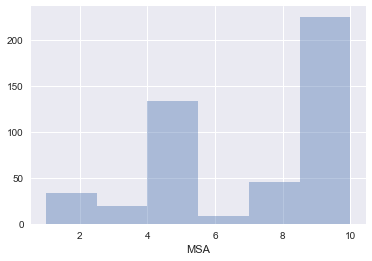

In [8]:
sns.distplot(all_df['MSA'].value_counts(), kde=False);

Many of the MSAs didn't survive the merge across all the years (not even 1 is in all 10 years). We'll have to see where this drops off.

Cut another way, are there some years that are particularly problematic?

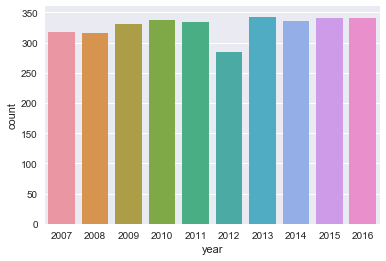

In [9]:
sns.countplot(x='year', data=all_df)

## Begining EDA - Basic Correlations

In general, do crimes tend to cluster together? I'd expect these relationships to be relatively high considering "safe" and "dangerous" neighborhoods.

In [11]:
np.random.seed(42)
df_train, df_test = train_test_split(all_df, test_size=.3, stratify=all_df['year'])
print(df_train.shape)

(2298, 560)


/Users/kastman/miniconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


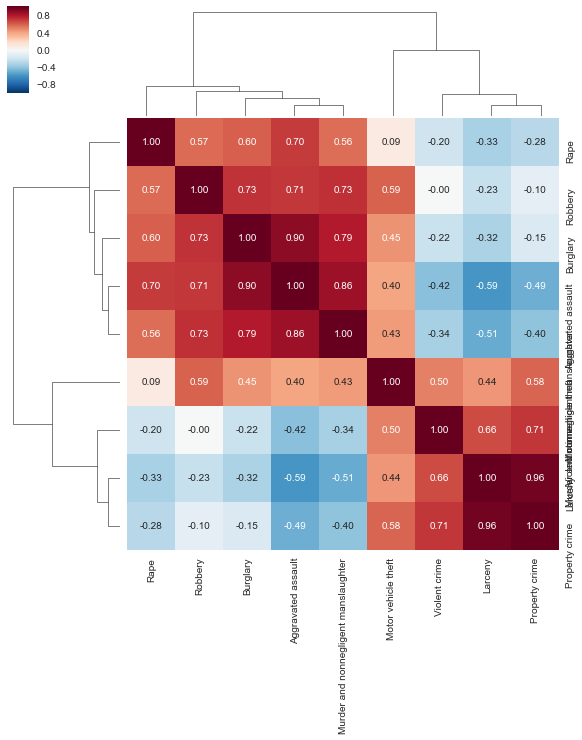

In [20]:
crime_columns = ['Aggravated assault', 'Burglary', 'Counties/principal cities', 'Larceny',
                 'Motor vehicle theft', 'Murder and nonnegligent manslaughter', 'Property crime', 
                 'Rape', 'Robbery', 'Violent crime']
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.clustermap(df_train[crime_columns].corr().dropna(), annot=True, fmt='.02f', square=True);